In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os

dataset_path = os.listdir('hahaha')

room_types = os.listdir('hahaha')
print (room_types) 

print("categories of disease: ", len(dataset_path))

['normal', 'osteopenia', 'osteoporosis']
categories of disease:  3


In [2]:
rooms = []
for item in room_types:
    all_rooms = os.listdir('hahaha' + '/' +item)

    for room in all_rooms:
        
        rooms.append((item, str('hahaha' + '/' +item) + '/' + room))
#         print(rooms)

In [3]:
osteo_df = pd.DataFrame(data=rooms, columns=['Y', 'images'])
print(osteo_df)
osteo_df.shape

                Y                                   images
0          normal                    hahaha/normal/N1.JPEG
1          normal                   hahaha/normal/N10.JPEG
2          normal                   hahaha/normal/N11.JPEG
3          normal                   hahaha/normal/N12.JPEG
4          normal                    hahaha/normal/N13.jpg
..            ...                                      ...
606  osteoporosis  hahaha/osteoporosis/Osteoporosis_95.jpg
607  osteoporosis  hahaha/osteoporosis/Osteoporosis_96.jpg
608  osteoporosis  hahaha/osteoporosis/Osteoporosis_97.jpg
609  osteoporosis  hahaha/osteoporosis/Osteoporosis_98.jpg
610  osteoporosis  hahaha/osteoporosis/Osteoporosis_99.jpg

[611 rows x 2 columns]


(611, 2)

# VGG16

In [4]:
from tensorflow.keras.applications import VGG16

# Load pre-trained VGG16 model with imagenet weights
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Print model summary
vgg16_base.summary()





Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0  

In [5]:
images, Y = osteo_df['images'] , osteo_df['Y']

In [6]:
from sklearn.model_selection import train_test_split

# Split into train and test sets
train_x, test_x, train_y, test_y = train_test_split(images, Y, test_size=0.05, random_state=27)


In [7]:
a = np.array(test_y)
test_y.describe()

count               31
unique               3
top       osteoporosis
freq                12
Name: Y, dtype: object

In [8]:
categories, counts = np.unique(a, return_counts=True)
for category, count in zip(categories, counts):
    print(f'{category}: {count}')

normal: 11
osteopenia: 8
osteoporosis: 12


In [9]:
import cv2
import numpy as np

def preprocess_images(images):
    processed_images = []
    for img in images:
        img = cv2.imread(img)
        # Resize image to (224, 224)
        resized_img = cv2.resize(img, (224, 224))
        # Preprocess the image (normalize pixel values to range [0, 1])
        resized_img = resized_img / 255.0  
        processed_images.append(resized_img)
    return np.array(processed_images)

# Preprocess train and test images
train_x_processed = preprocess_images(train_x)
test_x_processed = preprocess_images(test_x)


In [10]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform target labels
train_y_encoded = label_encoder.fit_transform(train_y)
test_y_encoded = label_encoder.transform(test_y)

# Convert the encoded labels to one-hot encoded format
train_y_onehot = to_categorical(train_y_encoded)
test_y_onehot = to_categorical(test_y_encoded)


In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam
import tensorflow.python.keras
import keras.optimizers

# Add custom classification layers on top of pre-trained VGG16
vgg16_model = Sequential()
vgg16_model.add(vgg16_base)
vgg16_model.add(Flatten())
vgg16_model.add(Dense(128, activation='relu'))
vgg16_model.add(Dense(128, activation='relu'))
vgg16_model.add(Dense(128, activation='relu'))
vgg16_model.add(Dense(3, activation='softmax'))  # Assuming 3 classes for osteopenia, osteoporosis, and normal


# Freeze the layers of the pre-trained VGG16 model
for layer in vgg16_base.layers:
    layer.trainable = False

In [12]:
# Compile the model
vgg16_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = vgg16_model.fit(train_x_processed, train_y_onehot, batch_size=20, epochs=20, validation_data=(test_x_processed, test_y_onehot))

Epoch 1/20


29/29 [==============================] - 126s 4s/step - loss: 0.9530 - accuracy: 0.5259 - val_loss: 0.9305 - val_accuracy: 0.5806
Epoch 2/20
29/29 [==============================] - 115s 4s/step - loss: 0.7531 - accuracy: 0.6672 - val_loss: 0.8512 - val_accuracy: 0.7419
Epoch 3/20
29/29 [==============================] - 116s 4s/step - loss: 0.6814 - accuracy: 0.7000 - val_loss: 0.7756 - val_accuracy: 0.6129
Epoch 4/20
29/29 [==============================] - 116s 4s/step - loss: 0.6771 - accuracy: 0.6931 - val_loss: 1.2400 - val_accuracy: 0.6452
Epoch 5/20
29/29 [==============================] - 117s 4s/step - loss: 0.6091 - accuracy: 0.7586 - val_loss: 0.8470 - val_accuracy: 0.6774
Epoch 6/20
29/29 [==============================] - 115s 4s/step - loss: 0.4737 - accuracy: 0.8000 - val_loss: 0.7415 - val_accuracy: 0.7742
Epoch 7/20
29/29 [==============================] - 117s 4s/step - loss: 0.4235 - accuracy: 0.8276 - val_loss: 0.8378 - val_accuracy: 0.6774
Epoch 8/20


In [13]:
# Evaluate the model on the test set
loss, accuracy = vgg16_model.evaluate(test_x_processed, test_y_onehot)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


1/1 [==============================] - 3s 3s/step - loss: 1.4466 - accuracy: 0.6774
Test Loss: 1.446592926979065
Test Accuracy: 0.6774193644523621


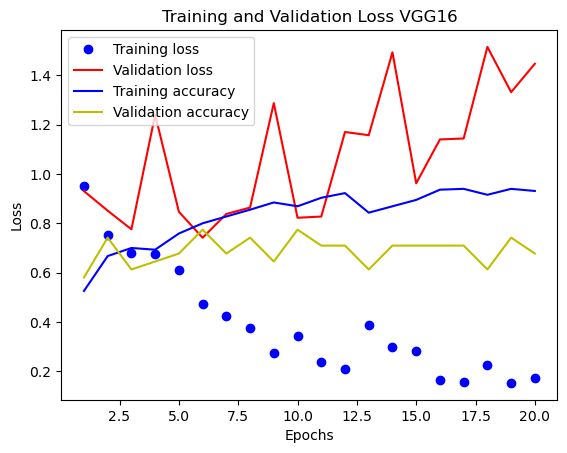

In [14]:
import matplotlib.pyplot as plt

def plot_loss(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(1, len(train_loss) + 1)

    plt.plot(epochs, train_loss, 'bo', label='Training loss')  # 'bo' for blue dots
    plt.plot(epochs, val_loss, 'r', label='Validation loss')  # 'r' for solid red line
    plt.plot(epochs, acc,'b', label='Training accuracy')
    plt.plot(epochs, val_acc ,'y', label = 'Validation accuracy')
    plt.title('Training and Validation Loss VGG16')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Assuming you have a 'history' object from your model's training process
plot_loss(history)


# VGG19

In [34]:
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model
import numpy as np

In [35]:
vgg19_base = VGG19(weights = 'imagenet')
vgg19_base.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam

# Add custom classification layers on top of pre-trained VGG16
vgg19_model = Sequential()
vgg19_model.add(vgg19_base)
vgg19_model.add(Flatten())
vgg19_model.add(Dense(128, activation='relu'))
vgg19_model.add(Dense(128, activation='relu'))
vgg19_model.add(Dense(128, activation='relu'))
vgg19_model.add(Dense(3, activation='softmax'))  # Assuming 3 classes for osteopenia, osteoporosis, and normal

In [37]:
# Freeze the layers of the pre-trained VGG16 model
for layer in vgg19_base.layers:
    layer.trainable = True

# Compile the model
vgg19_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [38]:
# Train the model
history1 = vgg19_model.fit(train_x_processed, train_y_onehot, batch_size=20, epochs=20, validation_data=(test_x_processed, test_y_onehot))

Epoch 1/20
29/29 [==============================] - 311s 10s/step - loss: 1.0906 - accuracy: 0.3534 - val_loss: 1.0848 - val_accuracy: 0.3871
Epoch 2/20
29/29 [==============================] - 295s 10s/step - loss: 1.0854 - accuracy: 0.3845 - val_loss: 1.0847 - val_accuracy: 0.3871
Epoch 3/20
29/29 [==============================] - 294s 10s/step - loss: 1.0854 - accuracy: 0.3845 - val_loss: 1.0864 - val_accuracy: 0.3871
Epoch 4/20
29/29 [==============================] - 299s 10s/step - loss: 1.0862 - accuracy: 0.3845 - val_loss: 1.0846 - val_accuracy: 0.3871
Epoch 5/20
29/29 [==============================] - 301s 10s/step - loss: 1.0833 - accuracy: 0.3845 - val_loss: 1.0851 - val_accuracy: 0.3871
Epoch 6/20
29/29 [==============================] - 4539s 162s/step - loss: 1.0848 - accuracy: 0.3638 - val_loss: 1.0848 - val_accuracy: 0.3871
Epoch 7/20
29/29 [==============================] - 301s 10s/step - loss: 1.0839 - accuracy: 0.3845 - val_loss: 1.0849 - val_accuracy: 0.3871
Epoc

In [24]:
# Evaluate the model on the test set
loss, accuracy = vgg19_model.evaluate(test_x_processed, test_y_onehot)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


1/1 [==============================] - 4s 4s/step - loss: 1.0851 - accuracy: 0.3871
Test Loss: 1.0850679874420166
Test Accuracy: 0.3870967626571655


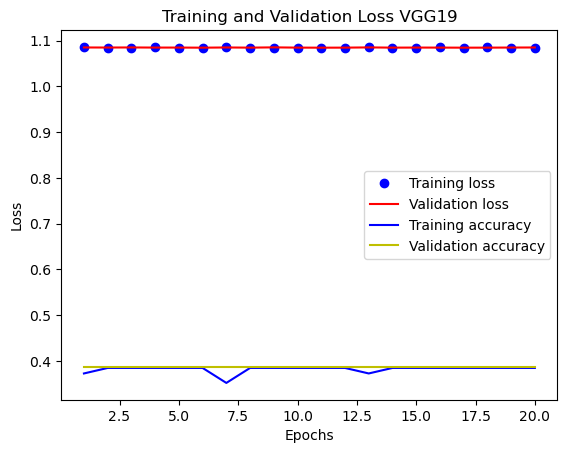

In [25]:
import matplotlib.pyplot as plt

def plot_loss(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(1, len(train_loss) + 1)

    plt.plot(epochs, train_loss, 'bo', label='Training loss')  # 'bo' for blue dots
    plt.plot(epochs, val_loss, 'r', label='Validation loss')  # 'r' for solid red line
    plt.plot(epochs, acc,'b', label='Training accuracy')
    plt.plot(epochs, val_acc ,'y', label = 'Validation accuracy')
    plt.title('Training and Validation Loss VGG19')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Assuming you have a 'history' object from your model's training process
plot_loss(history1)


# ResNet

In [26]:
import keras
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input,decode_predictions
import numpy as np

In [27]:
RNet_base = ResNet50(weights = 'imagenet')

In [28]:
RNet_base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

                                                                                                  
 conv2_block3_1_conv (Conv2  (None, 56, 56, 64)           16448     ['conv2_block2_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv2_block3_1_bn (BatchNo  (None, 56, 56, 64)           256       ['conv2_block3_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv2_block3_1_relu (Activ  (None, 56, 56, 64)           0         ['conv2_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv2_blo

 ation)                                                                                           
                                                                                                  
 conv3_block2_3_conv (Conv2  (None, 28, 28, 512)          66048     ['conv3_block2_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block2_3_bn (BatchNo  (None, 28, 28, 512)          2048      ['conv3_block2_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv3_block2_add (Add)      (None, 28, 28, 512)          0         ['conv3_block1_out[0][0]',    
                                                                     'conv3_block2_3_bn[0][0]']   
          

 conv4_block1_2_conv (Conv2  (None, 14, 14, 256)          590080    ['conv4_block1_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv4_block1_2_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block1_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block1_2_relu (Activ  (None, 14, 14, 256)          0         ['conv4_block1_2_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block1_0_conv (Conv2  (None, 14, 14, 1024)         525312    ['conv3_block4_out[0][0]']    
 D)       

                                                                                                  
 conv4_block3_out (Activati  (None, 14, 14, 1024)         0         ['conv4_block3_add[0][0]']    
 on)                                                                                              
                                                                                                  
 conv4_block4_1_conv (Conv2  (None, 14, 14, 256)          262400    ['conv4_block3_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv4_block4_1_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block4_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_blo

 D)                                                                                               
                                                                                                  
 conv4_block6_3_bn (BatchNo  (None, 14, 14, 1024)         4096      ['conv4_block6_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block6_add (Add)      (None, 14, 14, 1024)         0         ['conv4_block5_out[0][0]',    
                                                                     'conv4_block6_3_bn[0][0]']   
                                                                                                  
 conv4_block6_out (Activati  (None, 14, 14, 1024)         0         ['conv4_block6_add[0][0]']    
 on)                                                                                              
          

 conv5_block3_1_relu (Activ  (None, 7, 7, 512)            0         ['conv5_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv5_block3_2_conv (Conv2  (None, 7, 7, 512)            2359808   ['conv5_block3_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv5_block3_2_bn (BatchNo  (None, 7, 7, 512)            2048      ['conv5_block3_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_block3_2_relu (Activ  (None, 7, 7, 512)            0         ['conv5_block3_2_bn[0][0]']   
 ation)   

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam

# Add custom classification layers on top of pre-trained VGG16
RNet_model = Sequential()
RNet_model.add(RNet_base)
RNet_model.add(Flatten())
RNet_model.add(Dense(128, activation='relu'))
RNet_model.add(Dense(3, activation='softmax'))  # Assuming 3 classes for osteopenia, osteoporosis, and normal

In [30]:
# Freeze the layers of the pre-trained VGG16 model
for layer in RNet_base.layers:
    layer.trainable = False

# Compile the model
RNet_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [31]:
# Train the model
history = RNet_model.fit(train_x_processed, train_y_onehot, batch_size=20, epochs=20, validation_data=(test_x_processed, test_y_onehot))

Epoch 1/20
29/29 [==============================] - 33s 1s/step - loss: 1.0939 - accuracy: 0.3741 - val_loss: 1.0897 - val_accuracy: 0.3871
Epoch 2/20
29/29 [==============================] - 24s 845ms/step - loss: 1.0869 - accuracy: 0.3845 - val_loss: 1.0852 - val_accuracy: 0.3871
Epoch 3/20
29/29 [==============================] - 25s 854ms/step - loss: 1.0845 - accuracy: 0.3845 - val_loss: 1.0844 - val_accuracy: 0.3871
Epoch 4/20
29/29 [==============================] - 25s 874ms/step - loss: 1.0834 - accuracy: 0.3845 - val_loss: 1.0841 - val_accuracy: 0.3871
Epoch 5/20
29/29 [==============================] - 25s 850ms/step - loss: 1.0832 - accuracy: 0.3845 - val_loss: 1.0840 - val_accuracy: 0.3871
Epoch 6/20
29/29 [==============================] - 24s 846ms/step - loss: 1.0830 - accuracy: 0.3845 - val_loss: 1.0839 - val_accuracy: 0.3871
Epoch 7/20
29/29 [==============================] - 28s 970ms/step - loss: 1.0830 - accuracy: 0.3845 - val_loss: 1.0842 - val_accuracy: 0.3871
Ep

In [32]:
# Evaluate the model on the test set
loss, accuracy = RNet_model.evaluate(test_x_processed, test_y_onehot)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


1/1 [==============================] - 2s 2s/step - loss: 1.0821 - accuracy: 0.3871
Test Loss: 1.0821059942245483
Test Accuracy: 0.3870967626571655


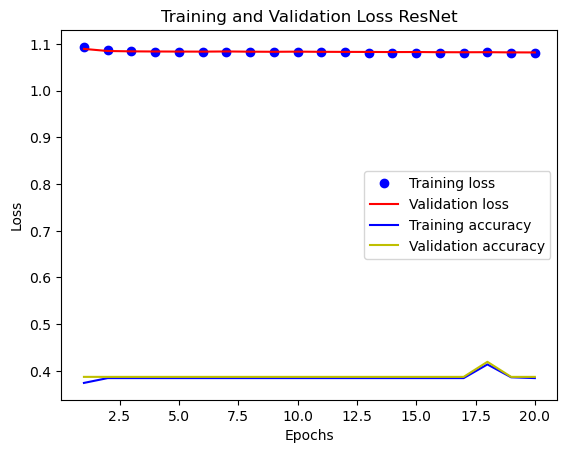

In [33]:
import matplotlib.pyplot as plt

def plot_loss(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(1, len(train_loss) + 1)

    plt.plot(epochs, train_loss, 'bo', label='Training loss')  # 'bo' for blue dots
    plt.plot(epochs, val_loss, 'r', label='Validation loss')  # 'r' for solid red line
    plt.plot(epochs, acc,'b', label='Training accuracy')
    plt.plot(epochs, val_acc ,'y', label = 'Validation accuracy')
    plt.title('Training and Validation Loss ResNet')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Assuming you have a 'history' object from your model's training process
plot_loss(history)


## AlexNet

In [95]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import GlorotNormal

In [96]:
import cv2
import numpy as np

def preprocess_images(images):
    processed_images = []
    for img in images:
        img = cv2.imread(img)
        # Resize image to (227, 227)
        resized_img = cv2.resize(img, (227, 227))
        # Preprocess the image (normalize pixel values to range [0, 1])
        resized_img = resized_img / 255.0  
        processed_images.append(resized_img)
    return np.array(processed_images)

# Preprocess train and test images
train_x_processed = preprocess_images(train_x)
test_x_processed = preprocess_images(test_x)


In [97]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform target labels
train_y_encoded = label_encoder.fit_transform(train_y)
test_y_encoded = label_encoder.transform(test_y)

# Convert the encoded labels to one-hot encoded format
train_y_onehot = to_categorical(train_y_encoded)
test_y_onehot = to_categorical(test_y_encoded)


In [98]:
def AlexNet(input_shape=(227, 227, 3), num_classes=3):
    # Input layer
    inputs = Input(shape=input_shape)

    # Layer 1
    x = Conv2D(96, (11, 11), strides=(4, 4), activation='relu', padding='valid', kernel_initializer = GlorotNormal())(inputs)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)

    # Layer 2
    x = Conv2D(256, (5, 5), activation='relu', padding='same',kernel_initializer = GlorotNormal())(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)

    # Layer 3
    x = Conv2D(384, (3, 3), activation='relu', padding='same',kernel_initializer = GlorotNormal())(x)

    # Layer 4
    x = Conv2D(384, (3, 3), activation='relu', padding='same',kernel_initializer = GlorotNormal())(x)

    # Layer 5
    x = Conv2D(256, (3, 3), activation='relu', padding='same',kernel_initializer = GlorotNormal())(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)

    # Flatten
    x = Flatten()(x)

    # Layer 6
    x = Dense(4096, activation='relu',kernel_initializer = GlorotNormal())(x)
    x = Dropout(0.5)(x)

    # Layer 7
    x = Dense(4096, activation='relu',kernel_initializer = GlorotNormal())(x)
    x = Dropout(0.5)(x)

    # Output layer
    outputs = Dense(num_classes, activation='softmax')(x)

    # Create model
    model = Model(inputs, outputs, name='alexnet')

    return model

In [40]:
import keras_tuner as kt

In [49]:
def build_model(hp):
    
    # Create AlexNet model
    alexnet_model = AlexNet(input_shape=(227, 227, 3), num_classes=3)
    optimizer = hp.Choice('optimizer', values = ['adam','sgd','rmsprop', 'adadelta'])
    
    alexnet_model.compile(optimizer = optimizer, loss='categorical_crossentropy', metrics = ['accuracy'])
    
    return alexnet_model

In [50]:
tuner = kt.RandomSearch(build_model, objective = 'val_accuracy',max_trials = 10)

In [51]:
tuner.search(train_x_processed, train_y_onehot, epochs = 15, validation_data=(test_x_processed, test_y_onehot))

Trial 4 Complete [00h 03m 44s]
val_accuracy: 0.5405405163764954

Best val_accuracy So Far: 0.5945945978164673
Total elapsed time: 00h 18m 28s


In [52]:
tuner.get_best_hyperparameters()[0].values

{'optimizer': 'adam'}

In [105]:
# Create AlexNet model
alexnet_model = AlexNet(input_shape=(227, 227, 3), num_classes=3)
optimizer = Adam(learning_rate = 0.0001)
    
alexnet_model.compile(optimizer = optimizer, loss='categorical_crossentropy', metrics = ['accuracy'])

In [107]:
history = alexnet_model.fit(train_x_processed, train_y_onehot, batch_size=32, epochs=50, validation_data=(test_x_processed, test_y_onehot))

Epoch 1/50
19/19 [==============================] - 20s 1s/step - loss: 2.5470 - accuracy: 0.3776 - val_loss: 1.0859 - val_accuracy: 0.3871
Epoch 2/50
19/19 [==============================] - 19s 977ms/step - loss: 1.0873 - accuracy: 0.3845 - val_loss: 1.0843 - val_accuracy: 0.3871
Epoch 3/50
19/19 [==============================] - 19s 999ms/step - loss: 1.1131 - accuracy: 0.3293 - val_loss: 1.0856 - val_accuracy: 0.3548
Epoch 4/50
19/19 [==============================] - 19s 997ms/step - loss: 1.0753 - accuracy: 0.3793 - val_loss: 1.0263 - val_accuracy: 0.4839
Epoch 5/50
19/19 [==============================] - 19s 996ms/step - loss: 1.0078 - accuracy: 0.4500 - val_loss: 1.0687 - val_accuracy: 0.3871
Epoch 6/50
19/19 [==============================] - 19s 999ms/step - loss: 0.9712 - accuracy: 0.5086 - val_loss: 1.0182 - val_accuracy: 0.4516
Epoch 7/50
19/19 [==============================] - 19s 985ms/step - loss: 0.9410 - accuracy: 0.5224 - val_loss: 0.9118 - val_accuracy: 0.4516
Ep

In [109]:
loss, accuracy = alexnet_model.evaluate(test_x_processed, test_y_onehot)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

1/1 [==============================] - 0s 297ms/step - loss: 1.0644 - accuracy: 0.7419
Test Loss: 1.0643584728240967
Test Accuracy: 0.7419354915618896


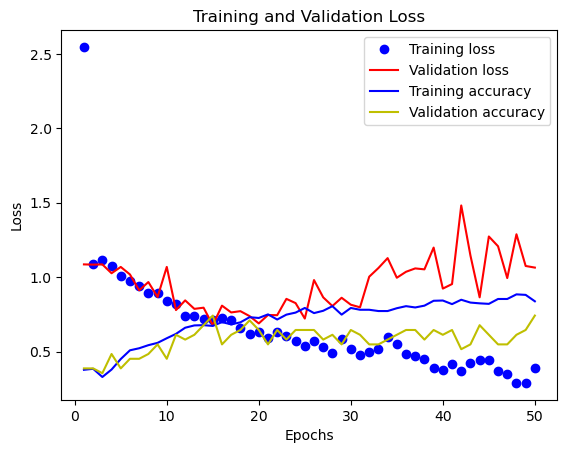

In [108]:
import matplotlib.pyplot as plt

def plot_loss(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(1, len(train_loss) + 1)

    plt.plot(epochs, train_loss, 'bo', label='Training loss')  # 'bo' for blue dots
    plt.plot(epochs, val_loss, 'r', label='Validation loss')  # 'r' for solid red line
    plt.plot(epochs, acc,'b', label='Training accuracy')
    plt.plot(epochs, val_acc ,'y', label = 'Validation accuracy')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Assuming you have a 'history' object from your model's training process
plot_loss(history)


In [110]:
alexnet_model.save("ALEXNET.h5")

C:\Users\piriy\anaconda3\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Inceptin V3

In [111]:
from keras.applications.inception_v3 import InceptionV3
from keras.layers import Input

# Define the input shape for your model
input_shape = (224, 224, 3)  

# Create an input tensor with the defined shape
input_tensor = Input(shape=input_shape)

In [112]:
import cv2
import numpy as np

def preprocess_images(images):
    processed_images = []
    for img in images:
        img = cv2.imread(img)
        # Resize image to (224, 224)
        resized_img = cv2.resize(img, (224, 224))
        # Preprocess the image (normalize pixel values to range [0, 1])
        resized_img = resized_img / 255.0  
        processed_images.append(resized_img)
    return np.array(processed_images)

# Preprocess train and test images
train_x_processed = preprocess_images(train_x)
test_x_processed = preprocess_images(test_x)


In [113]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform target labels
train_y_encoded = label_encoder.fit_transform(train_y)
test_y_encoded = label_encoder.transform(test_y)

# Convert the encoded labels to one-hot encoded format
train_y_onehot = to_categorical(train_y_encoded)
test_y_onehot = to_categorical(test_y_encoded)


In [114]:
inV3_base = InceptionV3(input_tensor=input_tensor, weights='imagenet', include_top=True)

In [115]:
inV3_base.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_35 (Conv2D)          (None, 111, 111, 32)         864       ['input_8[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 111, 111, 32)         96        ['conv2d_35[0][0]']           
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 111, 111, 32)         0         ['batch_normalizati

 conv2d_46 (Conv2D)          (None, 25, 25, 32)           6144      ['average_pooling2d[0][0]']   
                                                                                                  
 batch_normalization_5 (Bat  (None, 25, 25, 64)           192       ['conv2d_40[0][0]']           
 chNormalization)                                                                                 
                                                                                                  
 batch_normalization_7 (Bat  (None, 25, 25, 64)           192       ['conv2d_42[0][0]']           
 chNormalization)                                                                                 
                                                                                                  
 batch_normalization_10 (Ba  (None, 25, 25, 96)           288       ['conv2d_45[0][0]']           
 tchNormalization)                                                                                
          

                                                                                                  
 activation_17 (Activation)  (None, 25, 25, 96)           0         ['batch_normalization_17[0][0]
                                                                    ']                            
                                                                                                  
 activation_18 (Activation)  (None, 25, 25, 64)           0         ['batch_normalization_18[0][0]
                                                                    ']                            
                                                                                                  
 mixed1 (Concatenate)        (None, 25, 25, 288)          0         ['activation_12[0][0]',       
                                                                     'activation_14[0][0]',       
                                                                     'activation_17[0][0]',       
          

                                                                                                  
 conv2d_63 (Conv2D)          (None, 25, 25, 96)           55296     ['activation_27[0][0]']       
                                                                                                  
 batch_normalization_28 (Ba  (None, 25, 25, 96)           288       ['conv2d_63[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_28 (Activation)  (None, 25, 25, 96)           0         ['batch_normalization_28[0][0]
                                                                    ']                            
                                                                                                  
 conv2d_61 (Conv2D)          (None, 12, 12, 384)          995328    ['mixed2[0][0]']              
          

 conv2d_65 (Conv2D)          (None, 12, 12, 192)          147456    ['mixed3[0][0]']              
                                                                                                  
 conv2d_68 (Conv2D)          (None, 12, 12, 192)          172032    ['activation_32[0][0]']       
                                                                                                  
 conv2d_73 (Conv2D)          (None, 12, 12, 192)          172032    ['activation_37[0][0]']       
                                                                                                  
 conv2d_74 (Conv2D)          (None, 12, 12, 192)          147456    ['average_pooling2d_3[0][0]'] 
                                                                                                  
 batch_normalization_30 (Ba  (None, 12, 12, 192)          576       ['conv2d_65[0][0]']           
 tchNormalization)                                                                                
          

                                                                    ']                            
                                                                                                  
 average_pooling2d_4 (Avera  (None, 12, 12, 768)          0         ['mixed4[0][0]']              
 gePooling2D)                                                                                     
                                                                                                  
 conv2d_75 (Conv2D)          (None, 12, 12, 192)          147456    ['mixed4[0][0]']              
                                                                                                  
 conv2d_78 (Conv2D)          (None, 12, 12, 192)          215040    ['activation_42[0][0]']       
                                                                                                  
 conv2d_83 (Conv2D)          (None, 12, 12, 192)          215040    ['activation_47[0][0]']       
          

                                                                                                  
 activation_52 (Activation)  (None, 12, 12, 160)          0         ['batch_normalization_52[0][0]
                                                                    ']                            
                                                                                                  
 activation_57 (Activation)  (None, 12, 12, 160)          0         ['batch_normalization_57[0][0]
                                                                    ']                            
                                                                                                  
 average_pooling2d_5 (Avera  (None, 12, 12, 768)          0         ['mixed5[0][0]']              
 gePooling2D)                                                                                     
                                                                                                  
 conv2d_85

 batch_normalization_62 (Ba  (None, 12, 12, 192)          576       ['conv2d_97[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 batch_normalization_67 (Ba  (None, 12, 12, 192)          576       ['conv2d_102[0][0]']          
 tchNormalization)                                                                                
                                                                                                  
 activation_62 (Activation)  (None, 12, 12, 192)          0         ['batch_normalization_62[0][0]
                                                                    ']                            
                                                                                                  
 activation_67 (Activation)  (None, 12, 12, 192)          0         ['batch_normalization_67[0][0]
          

                                                                                                  
 conv2d_106 (Conv2D)         (None, 5, 5, 320)            552960    ['activation_70[0][0]']       
                                                                                                  
 conv2d_110 (Conv2D)         (None, 5, 5, 192)            331776    ['activation_74[0][0]']       
                                                                                                  
 batch_normalization_71 (Ba  (None, 5, 5, 320)            960       ['conv2d_106[0][0]']          
 tchNormalization)                                                                                
                                                                                                  
 batch_normalization_75 (Ba  (None, 5, 5, 192)            576       ['conv2d_110[0][0]']          
 tchNormalization)                                                                                
          

                                                                                                  
 activation_82 (Activation)  (None, 5, 5, 384)            0         ['batch_normalization_82[0][0]
                                                                    ']                            
                                                                                                  
 activation_83 (Activation)  (None, 5, 5, 384)            0         ['batch_normalization_83[0][0]
                                                                    ']                            
                                                                                                  
 batch_normalization_84 (Ba  (None, 5, 5, 192)            576       ['conv2d_119[0][0]']          
 tchNormalization)                                                                                
                                                                                                  
 activatio

                                                                                                  
 activation_88 (Activation)  (None, 5, 5, 384)            0         ['batch_normalization_88[0][0]
                                                                    ']                            
                                                                                                  
 activation_91 (Activation)  (None, 5, 5, 384)            0         ['batch_normalization_91[0][0]
                                                                    ']                            
                                                                                                  
 activation_92 (Activation)  (None, 5, 5, 384)            0         ['batch_normalization_92[0][0]
                                                                    ']                            
                                                                                                  
 batch_nor

In [116]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam

# Add custom classification layers on top of pre-trained VGG16
inV3_model = Sequential()
inV3_model.add(inV3_base)
inV3_model.add(Flatten())
inV3_model.add(Dense(128, activation='relu'))
inV3_model.add(Dense(3, activation='softmax'))  # Assuming 3 classes for osteopenia, osteoporosis, and normal

In [117]:
# Freeze the layers of the pre-trained VGG16 model
for layer in inV3_base.layers:
    layer.trainable = False

# Compile the model
inV3_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [118]:
# Train the model
history = inV3_model.fit(train_x_processed, train_y_onehot, batch_size=32, epochs=30, validation_data=(test_x_processed, test_y_onehot))

Epoch 1/30
19/19 [==============================] - 21s 646ms/step - loss: 1.0845 - accuracy: 0.4397 - val_loss: 1.0503 - val_accuracy: 0.5161
Epoch 2/30
19/19 [==============================] - 11s 561ms/step - loss: 1.0471 - accuracy: 0.5207 - val_loss: 1.0121 - val_accuracy: 0.5484
Epoch 3/30
19/19 [==============================] - 11s 559ms/step - loss: 1.0075 - accuracy: 0.5310 - val_loss: 0.9664 - val_accuracy: 0.7419
Epoch 4/30
19/19 [==============================] - 11s 558ms/step - loss: 0.9624 - accuracy: 0.6052 - val_loss: 0.9243 - val_accuracy: 0.6452
Epoch 5/30
19/19 [==============================] - 11s 562ms/step - loss: 0.9180 - accuracy: 0.6517 - val_loss: 0.8771 - val_accuracy: 0.6129
Epoch 6/30
19/19 [==============================] - 11s 560ms/step - loss: 0.8727 - accuracy: 0.6759 - val_loss: 0.8457 - val_accuracy: 0.6129
Epoch 7/30
19/19 [==============================] - 11s 566ms/step - loss: 0.8348 - accuracy: 0.6810 - val_loss: 0.8233 - val_accuracy: 0.6129

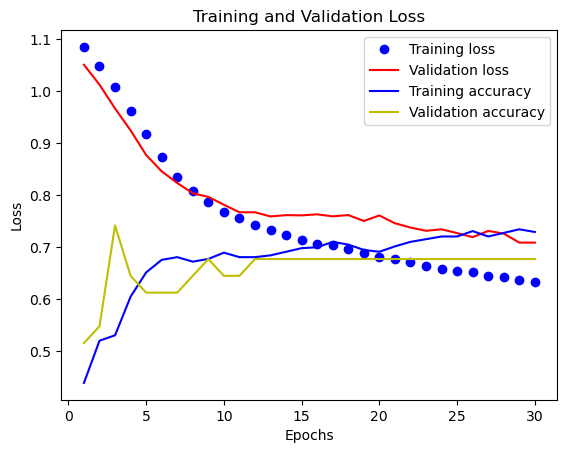

In [119]:
import matplotlib.pyplot as plt

def plot_loss(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(1, len(train_loss) + 1)

    plt.plot(epochs, train_loss, 'bo', label='Training loss')  # 'bo' for blue dots
    plt.plot(epochs, val_loss, 'r', label='Validation loss')  # 'r' for solid red line
    plt.plot(epochs, acc,'b', label='Training accuracy')
    plt.plot(epochs, val_acc ,'y', label = 'Validation accuracy')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Assuming you have a 'history' object from your model's training process
plot_loss(history)
